In [ ]:
!pip install gym-retro

     |████████████████████████████████| 162.0 MB 36 kB/s 


In [ ]:
import torch
import torch.nn as nn
DEVICE = torch.device('cuda')
import torchvision.models as models
import retro
import numpy as np

In [ ]:
env = retro.make(game='Airstriker-Genesis')

In [ ]:
import joblib
# colob中的路径
kmeans_died = joblib.load("/content/k_means_died")
kmeans_left = joblib.load("/content/k_means_left")
kmeans_right = joblib.load("/content/k_means_right")

In [ ]:
# env = retro.make(game='Airstriker-Genesis')
N_ACTIONS = env.action_space.n
N_TRANSITION = 6000
BEGIN_LEARN = 1536
BATCH_SIZE = 32
EPSILON = 0.85
FINAL_EPSILON = 0.999
EPISODE = 600
EPISODE_reward = 0
PARA_Replace = 400
GAMMA = 0.9
LR = 0.0001

# class NN(nn.Module):
#     def __init__(self):
#         super(NN, self).__init__()
#         # self.cnn = models.vgg19(pretrained=True).features.eval()
#         self.cnn = nn.Sequential(
#             nn.Conv2d(3, 16, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
#             nn.BatchNorm2d(16,affine=True),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
#             nn.Conv2d(16, 24, kernel_size=(3,3), stride=(1,1),padding=(1,1)),
#             nn.BatchNorm2d(24,affine=True),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
#         )
#
#         # self.cnn = models.vgg19(pretrained=True).features.to(DEVICE).eval().requires_grad_(requires_grad=False)
#         self.pool = nn.Sequential(
#             nn.AdaptiveAvgPool2d(output_size=(7, 7))
#         )
#         self.fc = nn.Sequential(
#             nn.Linear(1176, 512),
#             nn.BatchNorm1d(512,affine=True),
#             nn.ReLU(),
#             nn.Linear(512, 128),
#             nn.BatchNorm1d(128,affine=True),
#             nn.ReLU(),
#             nn.Linear(128, 11)
#         )
#
#     def forward(self, x):
#         x2 = x.permute(0,3,2,1)
#         y = self.cnn(x2)
#         y1 = self.pool(y)
#         y1 = torch.flatten(y1, start_dim=1, end_dim=-1)
#         z = self.fc(y1)
#         return z

class D3NN(nn.Module):
    def __init__(self):
        super(D3NN, self).__init__()
        # self.cnn = models.vgg19(pretrained=True).features.eval()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(16,affine=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(16, 24, kernel_size=(3,3), stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(24,affine=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )

        # self.cnn = models.vgg19(pretrained=True).features.to(DEVICE).eval().requires_grad_(requires_grad=False)
        self.pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(7, 7))
        )
        self.fc = nn.Sequential(
            nn.Linear(1176, 256),
            nn.BatchNorm1d(256,affine=True),
            nn.ReLU(),
        )
        self.adv = nn.Sequential(
            nn.Linear(256, 32),
            nn.BatchNorm1d(32,affine=True),
            nn.ReLU(),
            nn.Linear(32, 3)
        )
        self.val = nn.Sequential(
            nn.Linear(256, 32),
            nn.BatchNorm1d(32,affine=True),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x2 = x.permute(0,3,2,1)
        y = self.cnn(x2)
        y1 = self.pool(y)
        y1 = torch.flatten(y1, start_dim=1, end_dim=-1)
        z = self.fc(y1)
        val = self.val(z)
        adv = self.adv(z)
        # print(adv.shape)
        adv_avg = torch.mean(adv)
        q = adv + val - adv_avg
        return q


class D3QN(nn.Module):
    def __init__(self):
        super(D3QN, self).__init__()
        # self.target_net, self.action_net = NN().to(DEVICE), NN().to(DEVICE)
        self.target_net, self.action_net = D3NN().to(DEVICE), D3NN().to(DEVICE)
        self.target_net.load_state_dict(self.action_net.state_dict())
        # self.memory = np.zeros((N_TRANSITION, 4), dtype=object)

        self.s_mem = torch.empty((N_TRANSITION,200,320,3)).to(DEVICE)
        self.a_mem = torch.empty((N_TRANSITION,12)).to(DEVICE)
        self.r_mem = torch.empty((N_TRANSITION,1)).to(DEVICE)
        self.s__mem = torch.empty((N_TRANSITION,200,320,3)).to(DEVICE)

        self.memory_counter = 0
        self.learn_step = 0
        self.loss_func = nn.MSELoss().to(DEVICE)
        self.optimizer = torch.optim.Adam(self.action_net.parameters(), lr=LR)
        self.discrete_action = []
        self.decode_action()

        self.action_add = 0

    def decode_action(self):
        buttons = env.unwrapped.buttons
        combos = [[],['B'],['LEFT'],['RIGHT']]
        for combo in combos:
            arr = np.array([0] * env.action_space.n)
            # arr = [0,0,0,0,0,0,0,0,0,0,0,0]
            for button in combo:
                arr[buttons.index(button)] = 1
            self.discrete_action.append(arr)
        self.discrete_action = np.array(self.discrete_action)

    def store_transition(self, s, a, r, s_):

        index = self.memory_counter % N_TRANSITION

        # traintion = np.array([s, a, r, s_], dtype=object)
        # self.memory[index,:] = traintion

        self.s_mem[index,:,:,:] = torch.tensor(s).to(DEVICE)
        # print(torch.tensor(a).to(DEVICE))
        self.a_mem[index,:] = torch.tensor(a).to(DEVICE)
        self.r_mem[index,:] = torch.tensor(r).to(DEVICE)
        self.s__mem[index,:,:,:] = torch.tensor(s_).to(DEVICE)

        self.memory_counter += 1

    def action_select(self, s, n):
        global EPSILON
        # if n > 110:
        #     EPSILON += 0.1*0.5**(n-110)
        # action_value = self.action_net.forward(s)
        # action = self.discrete_action[torch.argmax(action_value)]
        if np.random.uniform() < EPSILON:
            action_value = self.action_net.forward(s)
            action = self.discrete_action[torch.argmax(action_value)]

        else:
            action = self.discrete_action[np.random.randint(0,3)]

        return action

    def learn(self):
        global PARA_Replace, EPSILON
        self.learn_step += 1
        if self.learn_step == 5:
            print("change para...")
            self.target_net.load_state_dict(self.action_net.state_dict())
            # for param, target_param in zip(self.action_net.parameters(), self.target_net.parameters()):
            #     target_param.data.copy_(0.1 * param.data + (1-0.1) * target_param.data)
            PARA_Replace = 100
        elif (self.learn_step-5) % PARA_Replace == 0:
            PARA_Replace = 100
            print("change para...")
            # self.target_net.load_state_dict(self.action_net.state_dict())
            for param, target_param in zip(self.action_net.parameters(), self.target_net.parameters()):
                target_param.data.copy_(0.05 * param.data + (1-0.05) * target_param.data)
        range = self.memory_counter if self.memory_counter<N_TRANSITION else N_TRANSITION
        sample_index = np.random.choice(range, BATCH_SIZE)
        # print(self.a_mem[sample_index,:])
        b_a_index = torch.tensor([[(self.discrete_action.tolist()).index(i.cpu().numpy().tolist())] for i in self.a_mem[sample_index,:]]).to(DEVICE)
        # print(b_a_index.shape)
        q_eval = self.action_net(self.s_mem[sample_index,:,:,:]).gather(1, b_a_index)
        q_next = self.target_net(self.s__mem[sample_index,:,:,:]).detach()
        q_target = self.r_mem[sample_index,:] + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)
        if EPSILON+0.0002<FINAL_EPSILON:
          EPSILON += 0.0002
        loss = self.loss_func(q_eval, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [ ]:
env.seed(23)
torch.manual_seed(23)
dqn = D3QN().to(DEVICE)
# dqn.load_state_dict(torch.load("/content/dqn_25.pth"))
episode_r = []
for i in range(EPISODE):
    s = (env.reset())[24:,:,:]
    EPISODE_reward = 0
    life = np.empty(2)
    life_index = 0
    while True:
        # if i > 20:
        # env.render()
        s1 = torch.tensor(s,dtype=torch.float).to(DEVICE)
        # print(s1.shape)
        a = dqn.eval().action_select(s1.unsqueeze(0), i)
        # print(a)
        s_, r, done, info = env.step(a)

        # 存储前后两帧的生死信息
        if_died = kmeans_died.predict([s_[128:135,120:207,:].flatten()])
        # print(if_died)
        # 0是活着，1是死了
        index = life_index % 2
        life[index] = if_died
        life_index+=1

        # 检测是否在左右两个角落，修改奖励来避免一直躲在角落
        right = kmeans_right.predict([s_[180:220,260:310,:].flatten()])
        left = kmeans_left.predict([s_[180:220,5:55,:].flatten()])
        # 0是最边上的角落里，1是不在那个小角落

        s_ = s_[24:,:,:]

        # 修改奖励(每帧存活就有奖励+2，死亡一条命-500，躲在角落里每帧-1)
        if r>0:
            r = 80  # 打掉飞机奖励改为80
        elif life[0]==0 and life[1]==0:
            r = 1
        elif life[(index+1)%2]==0 and life[index]==1: # 检测两帧的，防止死亡画面过长一直减分数
            r = -500
        if not (right and left):
          r -= 2
        # print(a)
        dqn.store_transition(s, a, r, s_)
        s = s_
        EPISODE_reward += r
        if dqn.memory_counter % BEGIN_LEARN == 0:   # 每1000个行动更新一次NN参数
            print("begin learning...%s"%{dqn.learn_step})
            dqn.train().learn()
        if done:
            print("episode%s---reward:%s"%(i, round(EPISODE_reward, 2)))
            episode_r.append(EPISODE_reward)
            break
torch.save(dqn.state_dict(),"/content/d3qn_soft_1536_600_100_3.pth")
env.close()

begin learning...{0}
episode0---reward:-365.0
begin learning...{1}
episode1---reward:468.0
begin learning...{2}
begin learning...{3}
episode2---reward:-147.0
begin learning...{4}
change para...
episode3---reward:-75.0
begin learning...{5}
episode4---reward:43.0
begin learning...{6}
episode5---reward:379.0
begin learning...{7}
episode6---reward:240.0
begin learning...{8}
begin learning...{9}
episode7---reward:341.0
begin learning...{10}
episode8---reward:132.0
begin learning...{11}
begin learning...{12}
episode9---reward:1247.0
begin learning...{13}
episode10---reward:-140.0
begin learning...{14}
episode11---reward:607.0
begin learning...{15}
episode12---reward:-166.0
begin learning...{16}
episode13---reward:150.0
begin learning...{17}
episode14---reward:202.0
begin learning...{18}
begin learning...{19}
episode15---reward:241.0
begin learning...{20}
episode16---reward:342.0
begin learning...{21}
episode17---reward:1032.0
begin learning...{22}
begin learning...{23}
episode18---reward:391

In [ ]:
EPSILON

0.9877999999999848

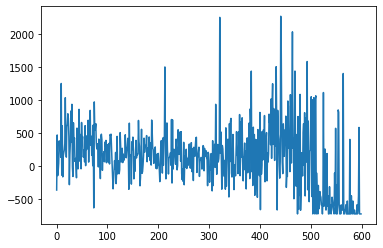

In [ ]:
import matplotlib.pyplot as plt
plt.plot(episode_r)